In [1]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 66 kB 850 kB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 244 kB 4.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=aab9992f1c154dc3765b86fa7e0fa8dfd35e2b8dfa49e20ce90de08d724741a6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=3ba13b0404ad0f35e4b7cd625d917de6593d59ff959120e9dfe62b2b70b57a27
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pathlib
import sys
import os
import random
import time
import numba
import cv2
import gc 
from tqdm.notebook import tqdm 
from sklearn.model_selection import KFold

#data structure
import pandas as pd

#graphics
import matplotlib.pyplot as plt
%matplotlib inline

#tiff file
import rasterio 
from rasterio.windows import Window 
from rasterio.enums import Resampling

#models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import segmentation_models_pytorch as smp

#data augmentation
import albumentations as A 
import torchvision
from torchvision import transforms as T

In [3]:
def set_seeds(seed=21):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
BASE_DIR = '../input/hubmap-kidney-segmentation'
SAVE_DIR = "/kaggle/working/"
SEED = 21
WINDOW = 1024
NEW_SIZE = 512
OVERLAP = 32 
EPOCHS = 20
BATCH_SIZE = 10
NUM_WORKERS = 4
REDUCE_RATE = 2
THRESHOLD = 50
NFOLDS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

torch.cuda.empty_cache()
set_seeds();

In [5]:
# used for converting the decoded image to rle mask
def mask2rle(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = (np.asarray(pixels[1:] != pixels[:-1]).nonzero())[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(NEW_SIZE, NEW_SIZE)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

#voir ce que fait cette fonction --> numba optimisé
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: 
        points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: 
        points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.T.flatten()
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=WINDOW, min_overlap=OVERLAP):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    
    nx = x // (window - min_overlap) + 1 # + 1 seulement si division reste 0?
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x) #assert x1.size == x2.size ?
    
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [6]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

#enlever mode si testdataset pas possible
class HubDataset(D.Dataset):
    def __init__(self, mode, transform=None, preprocessing=None):
        self.mode = mode #train or test
        self.transform = transform
        self.preprocessing = preprocessing
        #ajouter preprocessing
        name_csv = 'train.csv' if mode=='train' else 'sample_submission.csv'
        self.csv = pd.read_csv(f"{BASE_DIR}/{name_csv}", index_col=[0])
        
        self.x, self.y = [], []
        self.build_slices()
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, file_id in enumerate(self.csv.index.values):
            filepath = f'{BASE_DIR}/{self.mode}/{file_id}.tiff'
            self.files.append(filepath)
                                 
            print('Transform', filepath)
            with rasterio.open(filepath, transform=identity, driver='GTiff') as dataset:   
                if self.mode == 'train':
                    self.masks.append(rle2mask(self.csv.loc[file_id, 'encoding'], dataset.shape))
                
                slices = make_grid(dataset.shape, window=WINDOW, min_overlap=OVERLAP)
                for (x1,x2,y1,y2) in tqdm(slices):
                    use_slice = self.masks[-1][x1:x2,y1:y2].sum() > THRESHOLD if self.mode=='train' else True
                    if use_slice: 
                        self.slices.append([i,x1,x2,y1,y2])
                        image = dataset.read([1, 2, 3], #(r, g, b), h, w
                            window=Window.from_slices((x1,x2),(y1,y2)))
                        image = np.moveaxis(image, 0, -1) # h, w, (r, g, b)              
                        self.x.append(image)
                        
                        if self.mode == 'train':
                            mask = self.masks[-1][x1:x2,y1:y2]
                            mask = np.expand_dims(mask, axis=2)
                            self.y.append(mask)
    
    # get data operation
    def __getitem__(self, index):
        if self.mode == 'train':
            image, mask = self.x[index], self.y[index] #h, w, (r, g, b)
            if self.transform:
                augments = self.transform(image=image, mask=mask) #h, w, (r, g, b)
                image, mask = augments['image'], augments['mask']
            if self.preprocessing:
                preproc = self.preprocessing(image=image, mask=mask) #(r, g, b), h, w 
                image, mask = preproc['image'], preproc['mask']
            return image, mask
        
        else:
            image = self.x[index]
            if self.transform:
                augments = self.transform(image=image)
                image = augments['image']
            if self.preprocessing:
                preproc = self.preprocessing(image=image)
                image, mask = preproc['image']
            return image
    
    def __len__(self):
        return len(self.x)

In [7]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32') 

def get_preprocessing():
    _transform = [
        #A.Resize(380)
        A.Normalize(mean=(0.65459856, 0.48386562, 0.69428385), #mean images of dataset
                    std=(0.15167958, 0.23584107, 0.13146145), #std images of dataset
                    max_pixel_value=255.0, always_apply=True, p=1.0),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

# A. Datasets and loaders 

In [8]:
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        #A.Compose([
        #    A.VerticalFlip(p=0.5),              
        #    A.RandomRotate90(p=0.5)]
        #)
    ]
    return A.Compose(train_transform)


In [9]:
trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        A.ColorJitter(brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.0),
    A.ShiftScaleRotate(),
])

ds = HubDataset('train', transform=trfm, preprocessing=get_preprocessing())

Transform ../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Transform ../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff



Transform ../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff



Transform ../input/hubmap-kidney-segmentation/train/0486052bb.tiff



Transform ../input/hubmap-kidney-segmentation/train/e79de561c.tiff



Transform ../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff



Transform ../input/hubmap-kidney-segmentation/train/54f2eec69.tiff



Transform ../input/hubmap-kidney-segmentation/train/1e2425f28.tiff


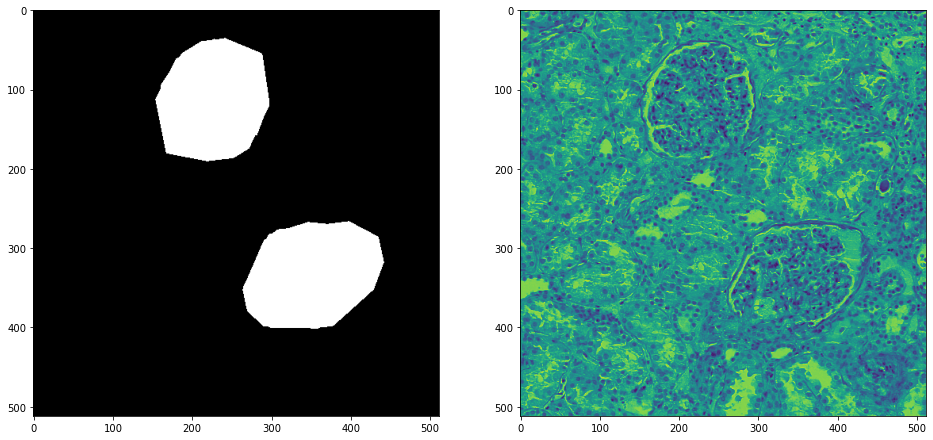

In [10]:
image, mask = ds[2]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

_ = rle_numba_encode(mask[0]) # compile function with numba

# B. Model

In [11]:
#https://github.com/qubvel/segmentation_models.pytorch#encoders
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet' #ssl, swsl
ACTIVATION = 'sigmoid' 
DROPOUT = 0.5
POOLING = 'avg'

def get_model():
    model = smp.Unet( #UnetPlusPlus ??
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS,
        activation = ACTIVATION,
        in_channels=3,
        classes=1)
    #dropout=DROPOUT,
    #pooling=POOLING
    
    return model

In [12]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [13]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth




        Train | Valid
Epoch |  Loss |  Loss | Time, m

     0│  0.660│  0.505│  2.01
Model saved!
     1│  0.418│  0.341│  1.98
Model saved!
     2│  0.310│  0.286│  1.99
Model saved!
     3│  0.268│  0.265│  1.98
Model saved!
     4│  0.251│  0.245│  1.98
Model saved!
     5│  0.237│  0.236│  1.98
Model saved!
     6│  0.228│  0.234│  1.98
Model saved!
     7│  0.223│  0.231│  1.99
Model saved!
     8│  0.219│  0.225│  1.98
Model saved!
     9│  0.217│  0.220│  1.98
Model saved!
    10│  0.218│  0.223│  1.98
    11│  0.215│  0.220│  1.98
    12│  0.210│  0.221│  1.99
    13│  0.210│  0.220│  1.99
    14│  0.209│  0.224│  1.99
    15│  0.207│  0.221│  1.98
    16│  0.205│  0.217│  1.98
Model saved!
    17│  0.204│  0.218│  1.99
    18│  0.210│  0.217│  1.98
Model saved!
    19│  0.205│  0.220│  1.98


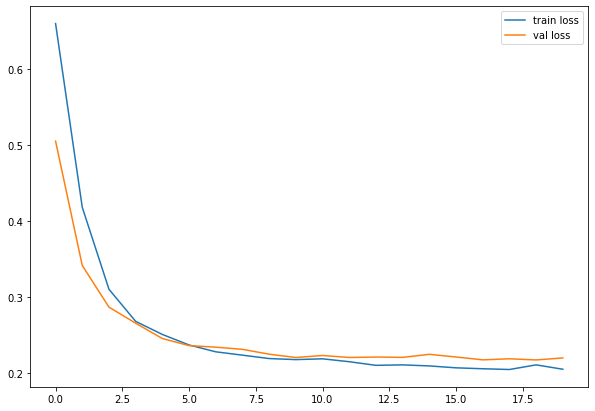


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     0│  0.687│  0.509│  1.99
Model saved!
     1│  0.422│  0.352│  1.99
Model saved!
     2│  0.319│  0.293│  1.98
Model saved!
     3│  0.275│  0.267│  1.98
Model saved!
     4│  0.250│  0.249│  1.98
Model saved!
     5│  0.239│  0.243│  1.98
Model saved!
     6│  0.229│  0.234│  1.98
Model saved!
     7│  0.224│  0.234│  1.99
     8│  0.222│  0.232│  1.98
Model saved!
     9│  0.220│  0.231│  1.99
Model saved!
    10│  0.217│  0.229│  1.98
Model saved!
    11│  0.213│  0.227│  1.98
Model saved!
    12│  0.212│  0.227│  1.99
Model saved!
    13│  0.209│  0.220│  1.99
Model saved!
    14│  0.209│  0.220│  1.98
Model saved!
    15│  0.210│  0.223│  1.98
    16│  0.207│  0.223│  1.99
    17│  0.204│  0.229│  1.99
    18│  0.205│  0.223│  1.98
    19│  0.204│  0.217│  2.00
Model saved!


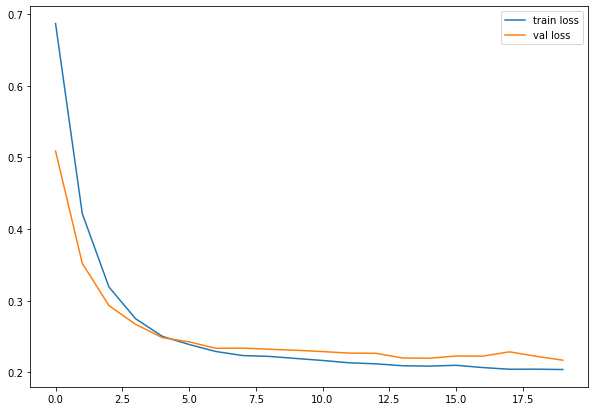


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     0│  0.731│  0.611│  2.00
Model saved!
     1│  0.520│  0.433│  1.98
Model saved!
     2│  0.381│  0.336│  1.98
Model saved!
     3│  0.307│  0.290│  1.99
Model saved!
     4│  0.277│  0.266│  1.98
Model saved!
     5│  0.252│  0.256│  1.98
Model saved!
     6│  0.238│  0.254│  1.98
Model saved!
     7│  0.232│  0.246│  1.99
Model saved!
     8│  0.228│  0.229│  1.99
Model saved!
     9│  0.228│  0.239│  1.99
    10│  0.221│  0.226│  1.99
Model saved!
    11│  0.216│  0.220│  1.98
Model saved!
    12│  0.214│  0.234│  2.00
    13│  0.215│  0.222│  1.99
    14│  0.212│  0.216│  1.99
Model saved!
    15│  0.210│  0.219│  2.00
    16│  0.208│  0.214│  1.99
Model saved!
    17│  0.207│  0.212│  1.99
Model saved!
    18│  0.207│  0.212│  2.00
Model saved!
    19│  0.206│  0.214│  1.99


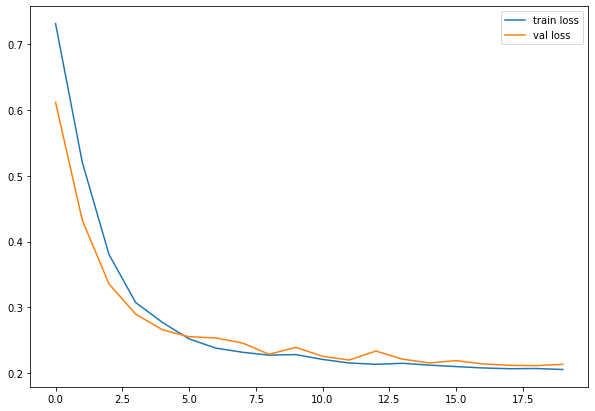


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     0│  0.737│  0.665│  2.00
Model saved!
     1│  0.555│  0.511│  1.99
Model saved!
     2│  0.430│  0.414│  1.98
Model saved!
     3│  0.351│  0.346│  1.99
Model saved!
     4│  0.304│  0.315│  2.00
Model saved!
     5│  0.276│  0.287│  1.99
Model saved!
     6│  0.256│  0.269│  1.99
Model saved!
     7│  0.242│  0.266│  2.00
Model saved!
     8│  0.235│  0.255│  2.00
Model saved!
     9│  0.229│  0.247│  1.99
Model saved!
    10│  0.223│  0.254│  1.98
    11│  0.217│  0.252│  2.00
    12│  0.215│  0.241│  2.00
Model saved!
    13│  0.213│  0.233│  1.99
Model saved!
    14│  0.212│  0.228│  1.99
Model saved!
    15│  0.211│  0.236│  2.00
    16│  0.207│  0.228│  1.99
    17│  0.206│  0.232│  2.00
    18│  0.204│  0.228│  2.00
    19│  0.206│  0.235│  1.99


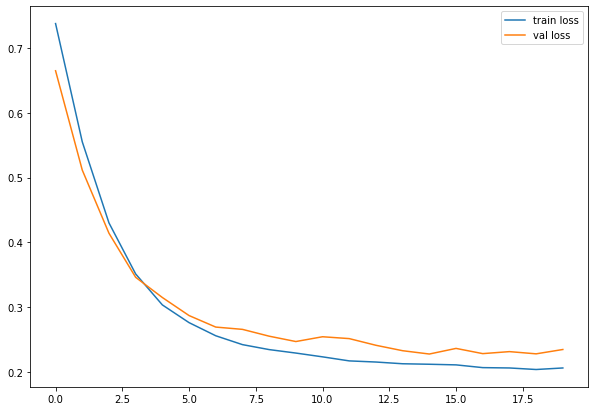

In [14]:
skf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
for fold,(train_idx, valid_idx) in enumerate(skf.split(ds)):
    #dataset
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)
    
    #dataloader
    train_loader = D.DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
   
    model = get_model()
    model.to(DEVICE)
    def loss_fn(y_pred, y_true):
        bce = nn.BCEWithLogitsLoss()(y_pred, y_true)
        dice = smp.utils.losses.DiceLoss()(y_pred, y_true)
        return 0.2*bce+ 0.8*dice
    #optimizer = torch.optim.AdamW(model.parameters(),
    #                  lr=1e-4, weight_decay=1e-3)
    #smp.utils.losses.BCEWithLogitsLoss()
    metrics = [smp.utils.metrics.IoU(threshold=0.5)]#dice
    optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

    best_loss = 5
    print(header)
    trains = []
    vals = []
    for epoch in range(EPOCHS):
        train_losses, val_losses = [], []
        start_time = time.time()
        
        model.train()
        for image, target in train_loader:
            image, target = image.to(DEVICE), target.float().to(DEVICE)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        
        with torch.no_grad():
            for image, target in val_loader:
                image, target = image.to(DEVICE), target.float().to(DEVICE)
                output = model(image)
                loss = loss_fn(output, target)
                val_losses.append(loss.item())
            
        train_loss = np.array(train_losses).mean()
        val_loss = np.array(val_losses).mean()
        trains.append(train_loss)
        vals.append(val_loss)
        print(raw_line.format(epoch, 
                              train_loss, 
                              val_loss,
                              (time.time()-start_time)/60**1))
        
        if best_loss > val_loss:
            best_loss = val_loss
            torch.save(model, os.path.join(SAVE_DIR, f'best_model_{fold}.pth'))
            print('Model saved!')
        
    #plot
    plt.figure(figsize=(10,7))
    plt.plot(trains, label='train loss')
    plt.plot(vals, label='val loss')
    plt.legend()
    plt.show();            

In [15]:
best_model = torch.load(os.path.join(SAVE_DIR, 'best_model_1.pth'), map_location=torch.device(DEVICE))

In [16]:
best_model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        